In [4]:
import numpy as np
import pandas as pd
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))


/kaggle/input/digit-recognizer/sample_submission.csv
/kaggle/input/digit-recognizer/train.csv
/kaggle/input/digit-recognizer/test.csv


In [5]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms, models
from tqdm import tqdm
from torch.utils.data import DataLoader, Dataset


In [6]:
transformMnist = transforms.Compose([
    transforms.Resize((32, 32)),
    transforms.Grayscale(num_output_channels=3),
    transforms.ToTensor(),
])

transformCifar = transforms.Compose([
    transforms.ToTensor(),
])

mnistTr = datasets.MNIST(root='./data', train=True, download=True, transform=transformMnist)
mnistTe = datasets.MNIST(root='./data', train=False, download=True, transform=transformMnist)
cifarTr = datasets.CIFAR10(root='./data', train=True, download=True, transform=transformCifar)
cifarTe = datasets.CIFAR10(root='./data', train=False, download=True, transform=transformCifar)

print(f'Length of MNIST training set: {len(mnistTr)}')
print(f'Length of MNIST test set: {len(mnistTe)}')
print(f'Length of CIFAR-10 training set: {len(cifarTr)}')
print(f'Length of CIFAR-10 test set: {len(cifarTe)}')


Files already downloaded and verified
Files already downloaded and verified
Length of MNIST training set: 60000
Length of MNIST test set: 10000
Length of CIFAR-10 training set: 50000
Length of CIFAR-10 test set: 10000


In [7]:
class CombinedDataset(Dataset):
    def __init__(self, mnistData, cifarData):
        self.mnistData = mnistData
        self.cifarData = cifarData

    def __len__(self):
        return min(len(self.mnistData), len(self.cifarData))

    def __getitem__(self, idx):
        mnistIMG, _ = self.mnistData[idx]
        cifarIMG, _ = self.cifarData[idx]
        combinedIMG = (mnistIMG + cifarIMG) / 2
        return combinedIMG, cifarIMG, mnistIMG

In [8]:
combinedDataset = CombinedDataset(mnistTr, cifarTr)
combinedLoader = DataLoader(combinedDataset, batch_size=64, shuffle=True)

In [9]:
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        resnet = models.resnet50(pretrained=True)
        self.encoder = nn.Sequential(*list(resnet.children())[:-2])

        self.decoderCifar = nn.Sequential(
            nn.ConvTranspose2d(2048, 1024, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(1024, 512, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(512, 256, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(256, 128, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(128, 3, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.Sigmoid()
        )
        self.decoderMnist = nn.Sequential(
            nn.ConvTranspose2d(2048, 1024, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(1024, 512, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(512, 256, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(256, 128, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(128, 3, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.Sigmoid()
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded_cifar = self.decoderCifar(encoded)
        decoded_mnist = self.decoderMnist(encoded)
        return decoded_cifar, decoded_mnist

In [10]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


In [11]:
autoencoder = Autoencoder().to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(autoencoder.parameters(), lr=1e-3)

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [12]:
def add_images(mnistIMG, cifarIMG):
    combinedIMG = (mnistIMG + cifarIMG)/2
    return combinedIMG

In [13]:
num_epochs = 30

for epoch in range(num_epochs):
    epoch_loss = 0
    for combinedIMG, cifarIMG, mnistIMG in tqdm(combinedLoader, desc=f'Epoch {epoch+1}/{num_epochs}'):
        combinedIMG, cifarIMG, mnistIMG = combinedIMG.to(device), cifarIMG.to(device), mnistIMG.to(device)  # Move data to the device
        
        outputs_cifar, outputs_mnist = autoencoder(combinedIMG)
        loss_cifar = criterion(outputs_cifar, cifarIMG)
        loss_mnist = criterion(outputs_mnist, mnistIMG)
        loss = loss_cifar + loss_mnist
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        epoch_loss += loss.item()
    
    avg_loss = epoch_loss / len(combinedLoader)
    
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.4f}')

Epoch 1/30: 100%|██████████| 782/782 [01:40<00:00,  7.75it/s]


Epoch [1/30], Loss: 0.0734


Epoch 2/30: 100%|██████████| 782/782 [01:40<00:00,  7.76it/s]


Epoch [2/30], Loss: 0.0477


Epoch 3/30: 100%|██████████| 782/782 [01:40<00:00,  7.75it/s]


Epoch [3/30], Loss: 0.0429


Epoch 4/30: 100%|██████████| 782/782 [01:40<00:00,  7.76it/s]


Epoch [4/30], Loss: 0.0366


Epoch 5/30: 100%|██████████| 782/782 [01:40<00:00,  7.77it/s]


Epoch [5/30], Loss: 0.0320


Epoch 6/30: 100%|██████████| 782/782 [01:40<00:00,  7.76it/s]


Epoch [6/30], Loss: 0.0316


Epoch 7/30: 100%|██████████| 782/782 [01:40<00:00,  7.77it/s]


Epoch [7/30], Loss: 0.0357


Epoch 8/30: 100%|██████████| 782/782 [01:40<00:00,  7.76it/s]


Epoch [8/30], Loss: 0.0313


Epoch 9/30: 100%|██████████| 782/782 [01:40<00:00,  7.77it/s]


Epoch [9/30], Loss: 0.0302


Epoch 10/30: 100%|██████████| 782/782 [01:40<00:00,  7.76it/s]


Epoch [10/30], Loss: 0.0301


Epoch 11/30: 100%|██████████| 782/782 [01:40<00:00,  7.75it/s]


Epoch [11/30], Loss: 0.0283


Epoch 12/30: 100%|██████████| 782/782 [01:40<00:00,  7.77it/s]


Epoch [12/30], Loss: 0.0275


Epoch 13/30: 100%|██████████| 782/782 [01:40<00:00,  7.75it/s]


Epoch [13/30], Loss: 0.0261


Epoch 14/30: 100%|██████████| 782/782 [01:41<00:00,  7.74it/s]


Epoch [14/30], Loss: 0.0298


Epoch 15/30: 100%|██████████| 782/782 [01:40<00:00,  7.78it/s]


Epoch [15/30], Loss: 0.0277


Epoch 16/30: 100%|██████████| 782/782 [01:40<00:00,  7.76it/s]


Epoch [16/30], Loss: 0.0259


Epoch 17/30: 100%|██████████| 782/782 [01:40<00:00,  7.80it/s]


Epoch [17/30], Loss: 0.0256


Epoch 18/30: 100%|██████████| 782/782 [01:40<00:00,  7.80it/s]


Epoch [18/30], Loss: 0.0235


Epoch 19/30: 100%|██████████| 782/782 [01:40<00:00,  7.80it/s]


Epoch [19/30], Loss: 0.0226


Epoch 20/30: 100%|██████████| 782/782 [01:40<00:00,  7.80it/s]


Epoch [20/30], Loss: 0.0221


Epoch 21/30: 100%|██████████| 782/782 [01:41<00:00,  7.73it/s]


Epoch [21/30], Loss: 0.0211


Epoch 22/30: 100%|██████████| 782/782 [01:40<00:00,  7.75it/s]


Epoch [22/30], Loss: 0.0212


Epoch 23/30: 100%|██████████| 782/782 [01:40<00:00,  7.77it/s]


Epoch [23/30], Loss: 0.0205


Epoch 24/30: 100%|██████████| 782/782 [01:40<00:00,  7.78it/s]


Epoch [24/30], Loss: 0.0197


Epoch 25/30: 100%|██████████| 782/782 [01:41<00:00,  7.72it/s]


Epoch [25/30], Loss: 0.0189


Epoch 26/30: 100%|██████████| 782/782 [01:40<00:00,  7.76it/s]


Epoch [26/30], Loss: 0.0185


Epoch 27/30: 100%|██████████| 782/782 [01:40<00:00,  7.76it/s]


Epoch [27/30], Loss: 0.0183


Epoch 28/30: 100%|██████████| 782/782 [01:40<00:00,  7.76it/s]


Epoch [28/30], Loss: 0.0177


Epoch 29/30: 100%|██████████| 782/782 [01:40<00:00,  7.78it/s]


Epoch [29/30], Loss: 0.0175


Epoch 30/30: 100%|██████████| 782/782 [01:40<00:00,  7.76it/s]

Epoch [30/30], Loss: 0.0171


In [14]:
import matplotlib.pyplot as plt

def show_images(original, combined, decoded_cifar, decoded_mnist, n=10):
    plt.figure(figsize=(40, 15))
    for i in range(n):
        ax = plt.subplot(4, n, i + 1)
        plt.imshow(original[i].permute(1, 2, 0).cpu().numpy())
        ax.title.set_text('Original CIFAR')
        plt.axis('off')
        
        ax = plt.subplot(4, n, i + 1 + n)
        plt.imshow(combined[i].permute(1, 2, 0).cpu().numpy())
        ax.title.set_text('Combined Image')
        plt.axis('off')

        ax = plt.subplot(4, n, i + 1 + 2 * n)
        plt.imshow(decoded_cifar[i].permute(1, 2, 0).detach().cpu().numpy())
        ax.title.set_text('Decoded CIFAR')
        plt.axis('off')

        ax = plt.subplot(4, n, i + 1 + 3 * n)
        plt.imshow(decoded_mnist[i].permute(1, 2, 0).detach().cpu().numpy())
        ax.title.set_text('Decoded MNIST')
        plt.axis('off')
    plt.show()

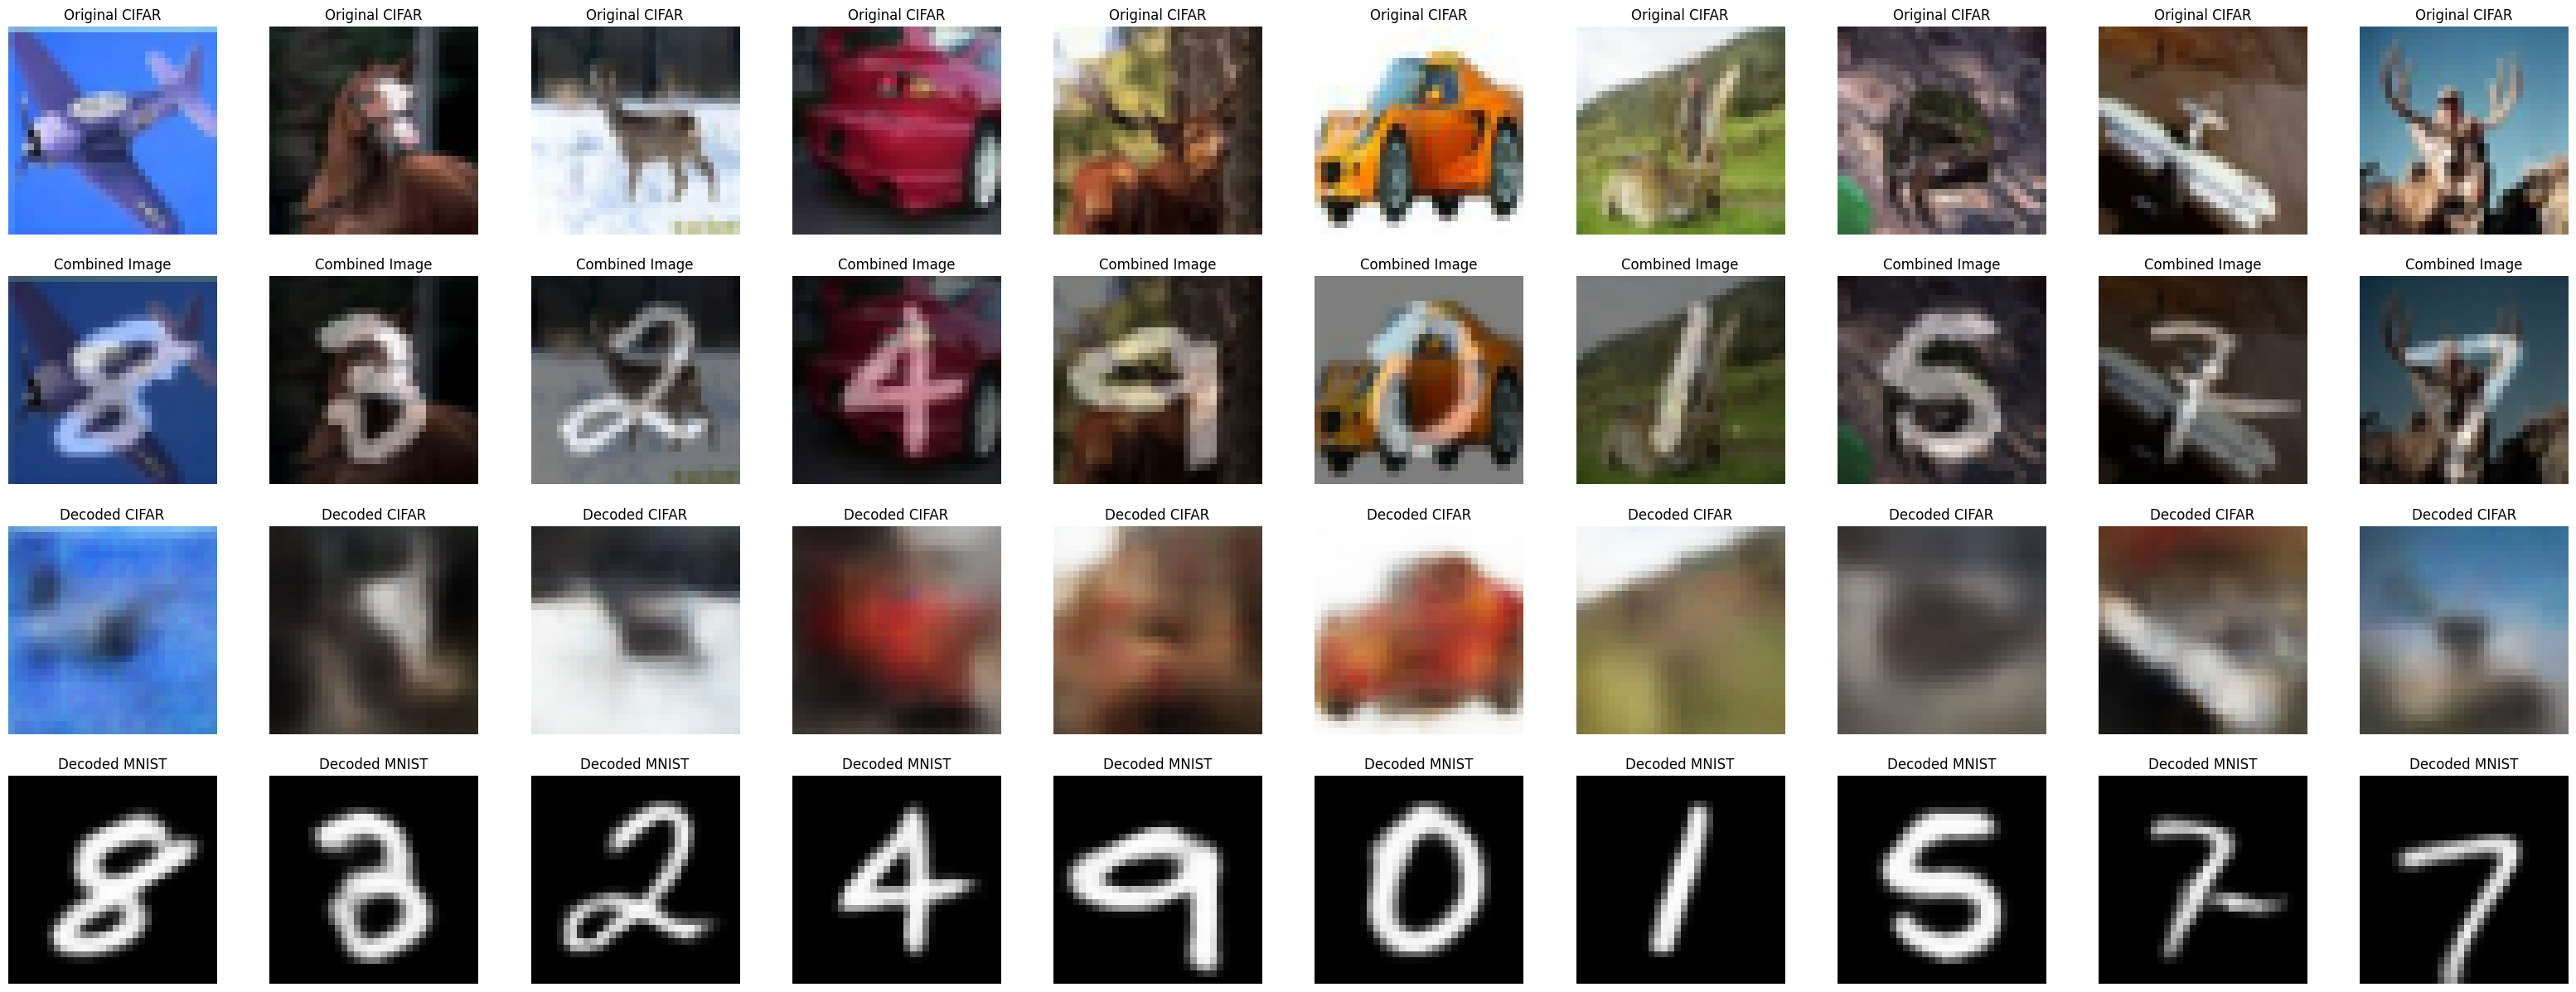

In [15]:
def visualize_results(autoencoder, data_loader):
    autoencoder.eval()
    with torch.no_grad():
        for combinedIMG, cifarIMG, mnistIMG in data_loader:
            combinedIMG, cifarIMG, mnistIMG = combinedIMG.to(device), cifarIMG.to(device), mnistIMG.to(device)  # Move data to the device
            outputs_cifar, outputs_mnist = autoencoder(combinedIMG)
            show_images(cifarIMG, combinedIMG, outputs_cifar, outputs_mnist)
            break

visualize_results(autoencoder, combinedLoader)

In [16]:
def psnr(img1, img2):
    mse = nn.functional.mse_loss(img1, img2)
    if mse == 0:
        return float('inf')
    return 20 * torch.log10(1.0 / torch.sqrt(mse))


In [17]:
combined_test_dataset = CombinedDataset(mnistTe, cifarTe)
combined_test_loader = DataLoader(combined_test_dataset, batch_size=64, shuffle=False)


In [18]:
def evaluate(autoencoder, test_loader):
    autoencoder.eval()
    psnr_cifar, psnr_mnist = 0, 0
    with torch.no_grad():
        for combinedIMG, cifarIMG, mnistIMG in tqdm(test_loader, desc='Evaluating'):
            combinedIMG, cifarIMG, mnistIMG = combinedIMG.to(device), cifarIMG.to(device), mnistIMG.to(device)  # Move data to the device
            outputs_cifar, outputs_mnist = autoencoder(combinedIMG)
            
            psnr_cifar += psnr(outputs_cifar, cifarIMG).item()
            psnr_mnist += psnr(outputs_mnist, mnistIMG).item()
    
    avg_psnr_cifar = psnr_cifar / len(test_loader)
    avg_psnr_mnist = psnr_mnist / len(test_loader)
    print(f'Average PSNR for CIFAR-10: {avg_psnr_cifar:.4f} dB')
    print(f'Average PSNR for MNIST: {avg_psnr_mnist:.4f} dB')


evaluate(autoencoder, combined_test_loader)

Evaluating: 100%|██████████| 157/157 [00:11<00:00, 13.14it/s]

Average PSNR for CIFAR-10: 18.5877 dB
Average PSNR for MNIST: 22.2202 dB
